In [29]:
# https://www.kaggle.com/competitions/sberbank-russian-housing-market/data

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [31]:
# Load data
house_data = pd.read_csv("Data/sberbank_housing.csv", index_col=0, low_memory=True)

print(f"Original dataset shape: {house_data.shape}")
print(f"Missing values per column:\n{house_data.isnull().sum()}")

Original dataset shape: (27000, 20)
Missing values per column:
id                     0
timestamp              0
price_doc              0
full_sq                0
life_sq             5537
kitch_sq            9572
floor                167
max_floor           9572
build_year         12869
num_room            9572
state              13067
product_type           0
ecology                0
sub_area               0
raion_popul            0
kindergarten_km        0
school_km              0
park_km                0
railroad_km            0
metro_min_walk        14
dtype: int64


DATA LOADING AND INITIAL EXPLORATION

In [32]:
# Clean column names
house_data.columns = [c.lower().strip().replace(" ", "_") for c in house_data.columns]

# Drop non-predictive columns
house_data = house_data.drop(columns=["timestamp", "id"])

In [33]:
# Display basic dataset information
print(f"Original dataset shape: {house_data.shape}")
print("Dataset contains {0} rows and {1} columns".format(house_data.shape[0], house_data.shape[1]))

Original dataset shape: (27000, 18)
Dataset contains 27000 rows and 18 columns


WHY CHECK TARGET DISTRIBUTION?

1. Normality Assumption - residuals follow bell-shaped curve distribution
2. Homoscedacity - residuals are scattered randomaly - no patterns

Target distribution is one of the biggest factors for both.

Homoscedastic + Normal residuals (IDEAL)

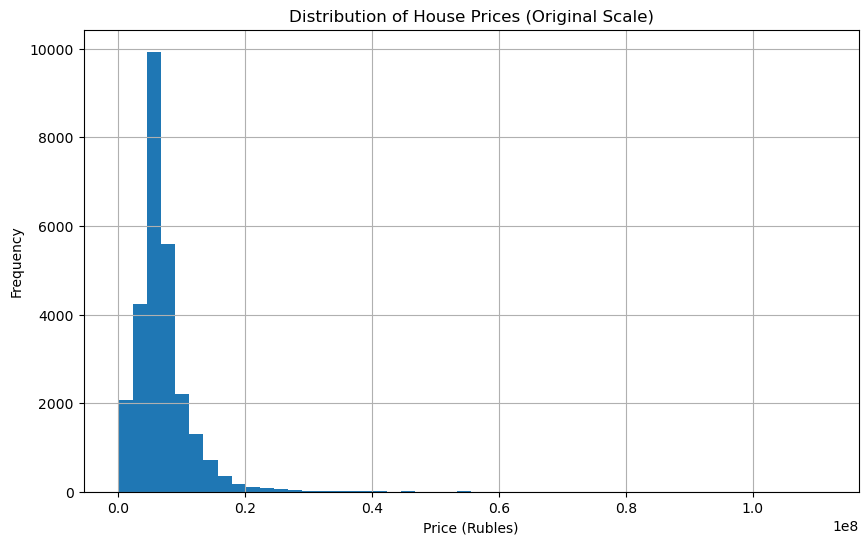

In [34]:
# Visualize the distribution of our target variable (house prices)
house_data["price_doc"].hist(bins=50, figsize=(10, 6))
plt.title("Distribution of House Prices (Original Scale)")
plt.xlabel("Price (Rubles)")
plt.ylabel("Frequency")
plt.show()

In [35]:
# Let's apply log transfrom to the target variable to reduce skewness
house_data["price_doc"] = np.log1p(house_data["price_doc"])

SPLIT DATA FIRST

80% for Training; 20% for Testing

In [36]:
X = house_data.drop("price_doc", axis=1)
y = house_data["price_doc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (21600, 17)
Test set: (5400, 17)


BASELINE MODEL - MINIMAL PREPROCESSING

In [37]:
# Only use numeric columns with no missing values for baseline
numeric_complete = X_train.select_dtypes(include=[np.number]).dropna(axis=1)
baseline_model = Ridge(random_state=42)
baseline_model.fit(numeric_complete, y_train)

numeric_complete_test = X_test[numeric_complete.columns]
baseline_pred = baseline_model.predict(numeric_complete_test)

In [38]:
# Calculate metrics on log scale
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Convert back to dollar scale for interpretation
baseline_pred_dollars = np.expm1(baseline_pred)
y_test_dollars = np.expm1(y_test)
baseline_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars))

residuals = y_test - baseline_pred

In [39]:
print(f"   Features used: {len(numeric_complete.columns)} (only complete numeric)")
print(f"   RMSE: {baseline_rmse:.3f} (log scale)")

print(f"\nFeatures used in baseline model:")
print(f"{list(numeric_complete.columns)}")

print("\n" + "="*60)
print("BASELINE MODEL LIMITATIONS:")
print("="*60)
print("Only uses complete numeric features")
print("Ignores categorical information")
print("Cannot handle missing values")
print("No feature engineering")
print("Limited feature set")

   Features used: 6 (only complete numeric)
   RMSE: 0.551 (log scale)

Features used in baseline model:
['full_sq', 'raion_popul', 'kindergarten_km', 'school_km', 'park_km', 'railroad_km']

BASELINE MODEL LIMITATIONS:
Only uses complete numeric features
Ignores categorical information
Cannot handle missing values
No feature engineering
Limited feature set


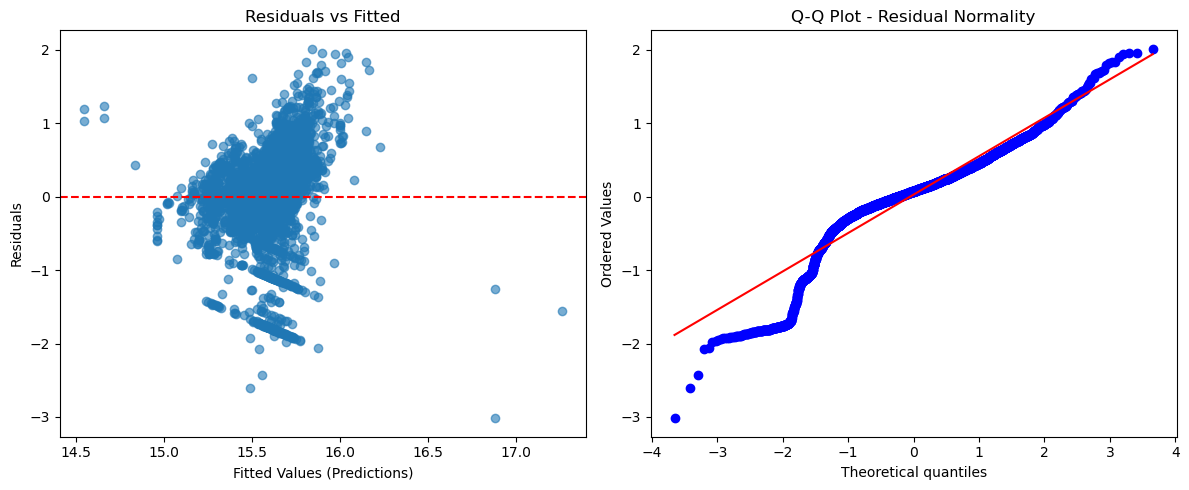

In [40]:
# Calculate residuals
residuals = y_test - baseline_pred

# 1. Check homoscedasticity
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(baseline_pred, residuals, alpha=0.6)
plt.xlabel("Fitted Values (Predictions)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(y=0, color='red', linestyle='--')

# 2. Check normality of residuals
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot - Residual Normality")

plt.tight_layout()
plt.show()

Both plots are not ideal, but acceptable, showing some minor deviations rather than major violations

Left Plot - Homoscedasticity: Good

Random cloud of points around y=0 
No obvious funnel/fan pattern 
No strong curved patterns 
Variance looks reasonably constant across prediction range

Right Plot - Normality: Mostly Good with Some Issues

Middle section: Points follow the diagonal line well 
Tails: Some deviation, especially in lower tail 
Overall: Reasonably normal but slightly heavy-tailed 

In [41]:
# save our baseline model's rmse to compare later
baseline_rmse_dollars = str(np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars)))
with open("baseline_rmse.txt","w") as f:
    f.write(baseline_rmse_dollars)
    f.flush()